# ***תרגיל 5 של הפרוייקט***

**Load Data and Basic Setup**

In [1]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("/content/train-filtered_question_level.csv")

# Remove duplicate questions
df = df.drop_duplicates(subset=["question"], keep="first")

# Extract text and difficulty levels
texts = df["question"].astype(str).tolist()
levels = df["level"].tolist()


**Balancing Dataset (Undersampling to Minority Class)**

In [ ]:
# import pandas as pd

# # 1. נגדיר את גודל היעד לפי המחלקה הקטנה ביותר (Hard)
# target_size = 15657

# # 2. נבצע דגימה מכל מחלקה בנפרד
# df_hard = df[df['level'] == 'hard']
# # כאן אנחנו לא עושים sample כי זה כבר הגודל שאנחנו רוצים

# df_medium_downsampled = df[df['level'] == 'medium'].sample(n=target_size, random_state=42)
# df_easy_downsampled = df[df['level'] == 'easy'].sample(n=target_size, random_state=42)

# # 3. נחבר את שלושתן יחד
# df_balanced = pd.concat([df_hard, df_medium_downsampled, df_easy_downsampled])

# # 4. נערבב את הדאטה (חשוב מאוד!)
# df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# # בדיקת תוצאה
# print("התפלגות חדשה:")
# print(df_balanced['level'].value_counts())

In [2]:
import pandas as pd

# 1. הגדרת גודל המדגם לכל קטגוריה (היפר-פרמטר של שלב הניסויים)
# התחלה עם 1000 מכל אחת עוזרת לבדיקה מהירה ("מתחילים בקטן" לפי ההוראות)
target_size = 7000

# 2. דגימה מאוזנת מכל הקטגוריות בבת אחת
# groupby מבטיח שנתייחס לכל רמת קושי בנפרד
df_balanced = df.groupby('level').apply(lambda x: x.sample(n=target_size, random_state=42)).reset_index(drop=True)

# 3. ערבוב הדאטה (Shuffle) - קריטי בלמידה עמוקה!
# כדי שה-Batch לא יכיל רק מחלקה אחת בזמן האימון, מה שיהרוס את הלמידה
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# בדיקת התפלגות כפי שנדרש בשלב ה-EDA ובניתוח הדאטה
print("התפלגות חדשה ומאוזנת:")
print(df_balanced['level'].value_counts())

התפלגות חדשה ומאוזנת:
level
easy      7000
medium    7000
hard      7000
Name: count, dtype: int64


/tmp/ipython-input-4281571597.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('level').apply(lambda x: x.sample(n=target_size, random_state=42)).reset_index(drop=True)


# ***================================================================================================================================================================================================================================================***

# **תחילת עריכה חדשה**

Imports + Seed

In [ ]:
import re
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
python
Copy code
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

טעינת דאטה + איזון

In [ ]:
# Load the dataset
df = pd.read_csv("/content/train-filtered_question_level.csv")

# Remove duplicate questions
df = df.drop_duplicates(subset=["question"], keep="first")

# Balanced sampling
target_size = 7000
df_balanced = (
    df.groupby("level")
      .apply(lambda x: x.sample(n=target_size, random_state=42))
      .reset_index(drop=True)
)

# Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("התפלגות חדשה ומאוזנת:")
print(df_balanced["level"].value_counts())


Labels mapping

In [ ]:
label2id = {"easy": 0, "medium": 1, "hard": 2}
id2label = {v: k for k, v in label2id.items()}

texts = df_balanced["question"].astype(str).tolist()
y = df_balanced["level"].map(label2id).to_numpy()

print("Example:", texts[0], "| label:", y[0], id2label[int(y[0])])


Tokenization + Vocab (PyTorch-only)

In [ ]:
TOKEN_RE = re.compile(r"[A-Za-z0-9]+(?:'[A-Za-z0-9]+)?|[^\sA-Za-z0-9]")

def tokenize(text: str):
    text = text.lower().strip()
    return TOKEN_RE.findall(text)


בניית vocab + encoding

In [ ]:
from collections import Counter

PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

def build_vocab(texts, min_freq=2, max_vocab_size=None):
    counter = Counter()
    for t in texts:
        counter.update(tokenize(t))

    # reserve 0 for PAD, 1 for UNK
    vocab = {PAD_TOKEN: 0, UNK_TOKEN: 1}
    items = [(w, c) for w, c in counter.items() if c >= min_freq]
    items.sort(key=lambda x: (-x[1], x[0]))  # freq desc, then alphabetic for determinism

    if max_vocab_size is not None:
        # max size includes PAD+UNK
        items = items[: max(0, max_vocab_size - 2)]

    for w, _ in items:
        vocab[w] = len(vocab)

    return vocab

vocab = build_vocab(texts, min_freq=2, max_vocab_size=None)
VOCAB_SIZE = len(vocab)
PAD_ID = vocab[PAD_TOKEN]
UNK_ID = vocab[UNK_TOKEN]

print("VOCAB_SIZE:", VOCAB_SIZE, "| PAD_ID:", PAD_ID, "| UNK_ID:", UNK_ID)


קביעת MAX_LEN לפי percentile

In [ ]:
encoded_lengths = [len(tokenize(t)) for t in texts]
MAX_LEN = int(np.percentile(encoded_lengths, 95))
MAX_LEN


padding + encoding

In [ ]:
def encode(text: str, vocab: dict, max_len: int):
    toks = tokenize(text)
    ids = [vocab.get(tok, UNK_ID) for tok in toks][:max_len]
    attn = [1] * len(ids)  # 1 for real tokens
    # pad
    pad_needed = max_len - len(ids)
    if pad_needed > 0:
        ids += [PAD_ID] * pad_needed
        attn += [0] * pad_needed
    return np.array(ids, dtype=np.int64), np.array(attn, dtype=np.int64)

X_ids = np.zeros((len(texts), MAX_LEN), dtype=np.int64)
X_attn = np.zeros((len(texts), MAX_LEN), dtype=np.int64)

for i, t in enumerate(texts):
    ids, attn = encode(t, vocab, MAX_LEN)
    X_ids[i] = ids
    X_attn[i] = attn

X_ids.shape, X_attn.shape


Stratified Split

In [ ]:
def stratified_split(X_ids, X_attn, y, test_size=0.15, val_size=0.15, seed=42):
    rng = np.random.default_rng(seed)
    n = len(y)

    idx_by_class = {}
    for c in np.unique(y):
        idx_by_class[c] = np.where(y == c)[0]

    test_idx, val_idx, train_idx = [], [], []

    for c, idxs in idx_by_class.items():
        idxs = idxs.copy()
        rng.shuffle(idxs)

        n_test = int(round(len(idxs) * test_size))
        n_val = int(round(len(idxs) * val_size))

        test_part = idxs[:n_test]
        val_part = idxs[n_test:n_test + n_val]
        train_part = idxs[n_test + n_val:]

        test_idx.extend(test_part.tolist())
        val_idx.extend(val_part.tolist())
        train_idx.extend(train_part.tolist())

    rng.shuffle(train_idx)
    rng.shuffle(val_idx)
    rng.shuffle(test_idx)

    def take(idxs):
        return X_ids[idxs], X_attn[idxs], y[idxs]

    return take(train_idx), take(val_idx), take(test_idx)

(train_ids, train_attn, y_train), (val_ids, val_attn, y_val), (test_ids, test_attn, y_test) = stratified_split(
    X_ids, X_attn, y, test_size=0.15, val_size=0.15, seed=42
)

print("Train:", len(y_train), "Val:", len(y_val), "Test:", len(y_test))


Dataset + DataLoaders

In [ ]:
class TriviaDataset(Dataset):
    def __init__(self, ids, attn, labels):
        self.ids = torch.tensor(ids, dtype=torch.long)
        self.attn = torch.tensor(attn, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return self.labels.size(0)

    def __getitem__(self, idx):
        return {
            "input_ids": self.ids[idx],
            "attention_mask": self.attn[idx],
            "labels": self.labels[idx]
        }

batch_size = 32

train_loader = DataLoader(TriviaDataset(train_ids, train_attn, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TriviaDataset(val_ids, val_attn, y_val), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TriviaDataset(test_ids, test_attn, y_test), batch_size=batch_size, shuffle=False)

next(iter(train_loader)).keys()


ExperimentConfig

In [ ]:
from dataclasses import dataclass
from typing import Literal, Optional

@dataclass
class ExperimentConfig:
    experiment_name: str

    # Model family
    model_type: Literal["BOW_MLP", "RNN", "LSTM", "GRU", "BiLSTM", "BiGRU"]
    hidden_dim: int = 128
    num_layers: int = 1
    dropout: float = 0.3

    # Embedding
    embedding_dim: int = 100
    embedding_mode: Literal["random"] = "random"   # השארנו random בלבד כדי להיות PyTorch-only
    embedding_trainable: bool = True

    # Training
    lr: float = 1e-3
    max_epochs: int = 20

    # Early stopping
    use_early_stopping: bool = True
    patience: int = 3


Models

In [ ]:
def masked_mean(embeddings, attention_mask):
    # embeddings: (B, T, D)
    # attention_mask: (B, T) with 1=token, 0=pad
    mask = attention_mask.unsqueeze(-1).float()  # (B, T, 1)
    summed = (embeddings * mask).sum(dim=1)      # (B, D)
    denom = mask.sum(dim=1).clamp(min=1.0)       # (B, 1)
    return summed / denom


BOW_MLP baseline

In [ ]:
class BowMLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, dropout, pad_id=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.net = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        emb = self.embedding(input_ids)                # (B, T, D)
        pooled = masked_mean(emb, attention_mask)      # (B, D)
        return self.net(pooled)


Sequence models: RNN/LSTM/GRU (+ Bi variants)

In [ ]:
class SeqClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, num_classes,
                 rnn_type: str, bidirectional: bool, dropout: float, pad_id=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)

        rnn_dropout = dropout if num_layers > 1 else 0.0
        if rnn_type == "RNN":
            self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers,
                              batch_first=True, bidirectional=bidirectional,
                              dropout=rnn_dropout)
        elif rnn_type == "LSTM":
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                               batch_first=True, bidirectional=bidirectional,
                               dropout=rnn_dropout)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers,
                              batch_first=True, bidirectional=bidirectional,
                              dropout=rnn_dropout)
        else:
            raise ValueError("Unsupported rnn_type")

        self.bidirectional = bidirectional
        out_dim = hidden_dim * (2 if bidirectional else 1)

        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(out_dim, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)          # (B, T, D)
        out, _ = self.rnn(x)                   # (B, T, H*dir)

        # Use last real token per example (not last padded position)
        lengths = attention_mask.sum(dim=1).clamp(min=1)          # (B,)
        last_idx = (lengths - 1).unsqueeze(1).unsqueeze(2)        # (B,1,1)
        last_idx = last_idx.expand(out.size(0), 1, out.size(2))   # (B,1,H*dir)
        last = out.gather(1, last_idx).squeeze(1)                 # (B,H*dir)

        return self.head(last)


Factory

In [ ]:
NUM_CLASSES = 3

def build_model(cfg: ExperimentConfig):
    if cfg.model_type == "BOW_MLP":
        return BowMLP(VOCAB_SIZE, cfg.embedding_dim, NUM_CLASSES, cfg.dropout, pad_id=PAD_ID)

    if cfg.model_type == "RNN":
        return SeqClassifier(VOCAB_SIZE, cfg.embedding_dim, cfg.hidden_dim, cfg.num_layers,
                             NUM_CLASSES, "RNN", False, cfg.dropout, pad_id=PAD_ID)

    if cfg.model_type == "LSTM":
        return SeqClassifier(VOCAB_SIZE, cfg.embedding_dim, cfg.hidden_dim, cfg.num_layers,
                             NUM_CLASSES, "LSTM", False, cfg.dropout, pad_id=PAD_ID)

    if cfg.model_type == "GRU":
        return SeqClassifier(VOCAB_SIZE, cfg.embedding_dim, cfg.hidden_dim, cfg.num_layers,
                             NUM_CLASSES, "GRU", False, cfg.dropout, pad_id=PAD_ID)

    if cfg.model_type == "BiLSTM":
        return SeqClassifier(VOCAB_SIZE, cfg.embedding_dim, cfg.hidden_dim, cfg.num_layers,
                             NUM_CLASSES, "LSTM", True, cfg.dropout, pad_id=PAD_ID)

    if cfg.model_type == "BiGRU":
        return SeqClassifier(VOCAB_SIZE, cfg.embedding_dim, cfg.hidden_dim, cfg.num_layers,
                             NUM_CLASSES, "GRU", True, cfg.dropout, pad_id=PAD_ID)

    raise ValueError("Unknown model_type")


Trainer + Early Stopping + History

In [ ]:
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.best = float("inf")
        self.counter = 0
        self.should_stop = False

    def step(self, val_loss):
        if val_loss < self.best:
            self.best = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True

def run_epoch(model, loader, optimizer, criterion, device, train: bool):
    model.train(train)
    total_loss, correct, total = 0.0, 0, 0

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        if train:
            optimizer.zero_grad()

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / max(total, 1), correct / max(total, 1)

def train_model(cfg: ExperimentConfig, train_loader, val_loader):
    model = build_model(cfg).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    es = EarlyStopping(patience=cfg.patience) if cfg.use_early_stopping else None

    for epoch in range(1, cfg.max_epochs + 1):
        tr_loss, tr_acc = run_epoch(model, train_loader, optimizer, criterion, device, train=True)
        va_loss, va_acc = run_epoch(model, val_loader, optimizer, criterion, device, train=False)

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)

        print(
            f"[{cfg.experiment_name}] Epoch {epoch}/{cfg.max_epochs} | "
            f"train_loss={tr_loss:.4f} train_acc={tr_acc:.4f} | "
            f"val_loss={va_loss:.4f} val_acc={va_acc:.4f}"
        )

        if es is not None:
            es.step(va_loss)
            if es.should_stop:
                print(f"[{cfg.experiment_name}] Early stopping (patience={cfg.patience})")
                break

    return model, history


Plots (Loss + Accuracy)

In [ ]:
def plot_training_curves(history, experiment_name):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.title(f"Loss Curves - {experiment_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.title(f"Accuracy Curves - {experiment_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


Evaluation (Report + Confusion Matrix plot)

In [ ]:
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)
            preds = logits.argmax(dim=1)

            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())

    print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(NUM_CLASSES)]))
    cm = confusion_matrix(y_true, y_pred)
    return cm

def plot_confusion_matrix(cm, class_names, experiment_name):
    cm = np.asarray(cm)

    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix - {experiment_name}")
    plt.colorbar()

    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)

    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()


Run Single Experiment

In [ ]:
def run_experiment(cfg: ExperimentConfig):
    print("="*90)
    print("EXPERIMENT:", cfg.experiment_name)
    print(cfg)
    print("="*90)

    model, history = train_model(cfg, train_loader, val_loader)
    plot_training_curves(history, cfg.experiment_name)

    cm = evaluate(model, test_loader)
    plot_confusion_matrix(cm, ["easy", "medium", "hard"], cfg.experiment_name)

    return {"config": cfg, "history": history, "cm": cm, "model": model}


# **סיום עריכה חדשה**

# ***================================================================================================================================================================================================================================================***

# **שלב 1**

# **א**

**Choosing Maximum Sequence Length (Documentation)**

In [ ]:
!pip install tensorflow

In [3]:
import numpy as np
import torch
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. חילוץ הטקסטים
texts = df_balanced['question'].astype(str).tolist()

# 2. אתחול והתאמת הטוקנייזר על כל המילים (בלי הגבלה שרירותית של 20,000)
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# 3. הגדרת VOCAB_SIZE האמיתי (קריטי למטריצת ה-Embedding)
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(f"Actual Vocabulary size: {VOCAB_SIZE}")

# 4. המרה לרצפים וביצוע Padding
sequences = tokenizer.texts_to_sequences(texts)
MAX_LEN = int(np.percentile([len(seq) for seq in sequences], 95)) # אורך שחוסם 95% מהמשפטים
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')


Actual Vocabulary size: 36543


**Padding and Truncation**

In [4]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# 1. הגדרת המילון (כפי שעשית)
label_dict = {'easy': 0, 'medium': 1, 'hard': 2}
y_integers = df_balanced['level'].map(label_dict).values

# 2. חלוקה מרובדת (Stratify) כדי לשמור על איזון באחוזים
# חלוקה ראשונה: מוציאים 15% לטסט סופי
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_integers,
    test_size=0.15,
    random_state=42,
    stratify=y_integers # מבטיח איזון
)

# חלוקה שנייה: פיצול היתרה לאימון וולידציה (15% מהסך הכל)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.176, # 0.15 / 0.85
    random_state=42,
    stratify=y_train_val # מבטיח איזון
)

print(f"Train size: {len(X_train)} | Val size: {len(X_val)} | Test size: {len(X_test)}")

Train size: 14708 | Val size: 3142 | Test size: 3150


In [5]:
# המרה ל-Tensors
# X הוא LongTensor כי הוא מכיל אינדקסים של מילים
# y הוא LongTensor כי CrossEntropyLoss מצפה לאינדקסים של מחלקות
train_ds = TensorDataset(torch.LongTensor(X_train), torch.LongTensor(y_train))
val_ds   = TensorDataset(torch.LongTensor(X_val), torch.LongTensor(y_val))
test_ds  = TensorDataset(torch.LongTensor(X_test), torch.LongTensor(y_test))

# יצירת Loaders
# shuffle=True רק באימון כדי שהמודל לא ילמד את סדר השאלות
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

print("PyTorch DataLoaders are ready!")

PyTorch DataLoaders are ready!


# **ב**

**ניסוי 1**

In [6]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 49.2 MB/s eta 0:00:00


In [7]:
from gensim.models import Word2Vec

# הכנת המשפטים לאימון (רשימה של רשימות מילים)
sentences_for_w2v = [text.split() for text in texts]

# אימון Word2Vec - לומד את הקשרים בין המילים בדאטה שלך
w2v_model = Word2Vec(sentences=sentences_for_w2v, vector_size=100, window=5, min_count=1, sg=1)

# יצירת מטריצת המשקולות (הגשר בין Word2Vec ל-PyTorch)
EMBED_DIM = 100
# VOCAB_SIZE צריך להיות שווה ל- len(tokenizer.word_index) + 1
embedding_matrix = torch.zeros((VOCAB_SIZE, EMBED_DIM))

for word, i in tokenizer.word_index.items():
    if i < VOCAB_SIZE:
        if word in w2v_model.wv:
            embedding_matrix[i] = torch.tensor(w2v_model.wv[word].copy())
        else:
            # מילים שלא קיימות ב-W2V מקבלות ערך אקראי קטן
            embedding_matrix[i] = torch.randn(EMBED_DIM) * 0.1

EMBED_MAT = embedding_matrix # נשמור את זה בשם ברור לניסויים

In [ ]:
class DifficultyModel(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, weights=None, is_frozen=False):
        super().__init__()
        if weights is not None:
            self.embedding = torch.nn.Embedding.from_pretrained(weights, freeze=is_frozen)
        else:
            self.embedding = torch.nn.Embedding(vocab_size, embed_dim)

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(embed_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(64, 3) # 3 קטגוריות
        )

    def forward(self, x):
        x = self.embedding(x).mean(dim=1) # Pooling
        return self.classifier(x)

def train_model(model, train_loader, val_loader, epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for texts_batch, labels_batch in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(texts_batch), labels_batch)
            loss.backward()
            optimizer.step()

    # חישוב דיוק סופי
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for texts_batch, labels_batch in val_loader:
            _, predicted = torch.max(model(texts_batch), 1)
            total += labels_batch.size(0)
            correct += (predicted == labels_batch).sum().item()
    return 100 * correct / total

**Embedding Layer מאומן מאפס**

In [ ]:
model_scratch = DifficultyModel(VOCAB_SIZE, EMBED_DIM)
acc_scratch = train_model(model_scratch, train_loader, val_loader)
print(f"Accuracy (Scratch): {acc_scratch:.2f}%")

Accuracy (Scratch): 49.68%


**The Frozen model**

In [ ]:
# ניסוי 2א: Word2Vec קפוא (Frozen)
model_frozen = DifficultyModel(VOCAB_SIZE, EMBED_DIM, weights=embedding_matrix, is_frozen=True)
acc_frozen = train_model(model_frozen, train_loader, val_loader)
print(f"Accuracy (W2V Frozen): {acc_frozen:.2f}%")

Accuracy (W2V Frozen): 50.99%


**Fine-tuned**

In [ ]:
# ניסוי 2ב: Word2Vec מכוונן (Fine-tuned)
model_tuned = DifficultyModel(VOCAB_SIZE, EMBED_DIM, weights=embedding_matrix, is_frozen=False)
acc_tuned = train_model(model_tuned, train_loader, val_loader)
print(f"Accuracy (W2V Fine-tuned): {acc_tuned:.2f}%")

Accuracy (W2V Fine-tuned): 49.65%


# **שלב 2**

**Basic Settings**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. ארכיטקטורת המודל
class FlexibleModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers,
                 model_type='LSTM', bidirectional=False, dropout_p=0.0,
                 embedding_matrix=None, is_frozen=False):
        super(FlexibleModel, self).__init__()
        self.dropout = nn.Dropout(dropout_p)
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        if embedding_matrix is not None:
            self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
            self.embedding.weight.requires_grad = not is_frozen
        else:
            self.embedding.weight.requires_grad = True

        rnn_dropout = dropout_p if n_layers > 1 else 0.0
        if model_type == 'RNN':
            self.rnn = nn.RNN(embed_dim, hidden_dim, n_layers, batch_first=True,
                              bidirectional=bidirectional, dropout=rnn_dropout)
        else:
            self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True,
                               bidirectional=bidirectional, dropout=rnn_dropout)

        num_directions = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_dim * num_directions, output_dim)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        if isinstance(hidden, tuple): hidden = hidden[0]
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            hidden = hidden[-1, :, :]
        return self.fc(hidden)

# 2. פונקציית אימון עם Patience
def run_experiment(model, train_loader, val_loader, epochs=5, lr=0.001, patience=3):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        total_val_loss, correct = 0.0, 0
        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                correct += (outputs.argmax(1) == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        acc = correct / len(val_loader.dataset)
        history['train_loss'].append(total_train_loss / len(train_loader))
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(acc)

        print(f"Epoch {epoch+1}/{epochs} | Val Loss: {avg_val_loss:.4f} | Val Acc: {acc:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(torch.load('best_model.pt'))
    return history

# 3. הערכת ביצועים - כולל מטריצת הבלבול הויזואלית!
def print_evaluation_section_c(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for texts, labels in loader:
            outputs = model(texts.to(device))
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    # הדפסת הדו"ח
    print("\n" + "="*30)
    print(classification_report(all_labels, all_preds, target_names=['Easy', 'Medium', 'Hard']))

    # ציור המטריצה
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Easy', 'Medium', 'Hard'],
                yticklabels=['Easy', 'Medium', 'Hard'])
    plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_training_history(history, model_name="Model"):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.legend(); plt.title(f"{model_name} - Loss")
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.legend(); plt.title(f"{model_name} - Accuracy")
    plt.show()

def print_misclassifications(model, dataloader, device, tokenizer, label_map, target_true='Medium', target_pred='Hard', num_examples=5):
    model.eval()
    results = []
    inv_label_map = {v: k for k, v in label_map.items()}
    true_idx = inv_label_map[target_true]
    pred_idx = inv_label_map[target_pred]

    def decode_text(text_tensor, tokenizer):
        return " ".join([tokenizer.index_word.get(i.item(), "") for i in text_tensor if i.item() > 0]).strip()

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            preds = model(texts).argmax(1)
            for i in range(len(labels)):
                if labels[i].item() == true_idx and preds[i].item() == pred_idx:
                    results.append(decode_text(texts[i], tokenizer))
                if len(results) >= num_examples: break
            if len(results) >= num_examples: break
    print(f"\n--- דוגמאות לטעות ({target_true} -> {target_pred}) ---")
    for j, text in enumerate(results): print(f"{j+1}) {text}\n")

In [ ]:
import torch

def decode_text(text_tensor, tokenizer):
    # הפיכת וקטור מספרים חזרה לטקסט קריא
    index_to_word = tokenizer.index_word
    words = [index_to_word.get(i.item(), "") for i in text_tensor if i.item() > 0]
    return " ".join(words).strip()

def print_misclassifications(model, dataloader, device, tokenizer, label_map, target_true='Medium', target_pred='Hard', num_examples=5):
    model.eval()
    results = []
    inv_label_map = {v: k for k, v in label_map.items()}
    true_idx = inv_label_map[target_true]
    pred_idx = inv_label_map[target_pred]

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            preds = outputs.argmax(1)

            for i in range(len(labels)):
                if labels[i].item() == true_idx and preds[i].item() == pred_idx:
                    original_text = decode_text(texts[i], tokenizer)
                    results.append(original_text)
                if len(results) >= num_examples: break
            if len(results) >= num_examples: break

    print(f"\n--- דוגמאות של {target_true} שסווגו בטעות כ-{target_pred} ---")
    if not results:
        print("לא נמצאו דוגמאות כאלו בניסוי הנוכחי.")
    else:
        for j, text in enumerate(results):
            print(f"{j+1}) {text}\n")

**RNN - Regular embedding**

--- מריץ ניסוי: RNN | BS=32 | Frozen=True ---
Epoch 1/10 | Val Loss: 1.0126 | Val Acc: 0.4192
Epoch 2/10 | Val Loss: 1.0658 | Val Acc: 0.3845
Epoch 3/10 | Val Loss: 1.0236 | Val Acc: 0.4064
Epoch 4/10 | Val Loss: 1.0597 | Val Acc: 0.3902
Early stopping at epoch 4

              precision    recall  f1-score   support

        Easy       0.98      0.27      0.43      1050
      Medium       0.00      0.00      0.00      1050
        Hard       0.37      1.00      0.54      1050

    accuracy                           0.42      3150
   macro avg       0.45      0.42      0.32      3150
weighted avg       0.45      0.42      0.32      3150



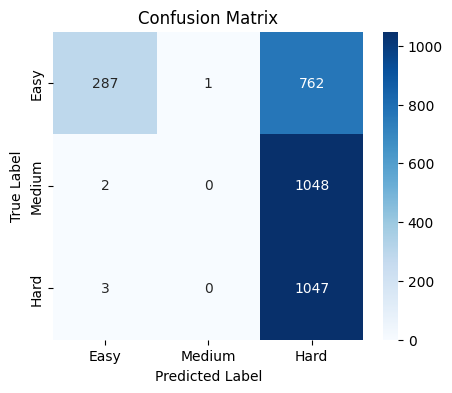

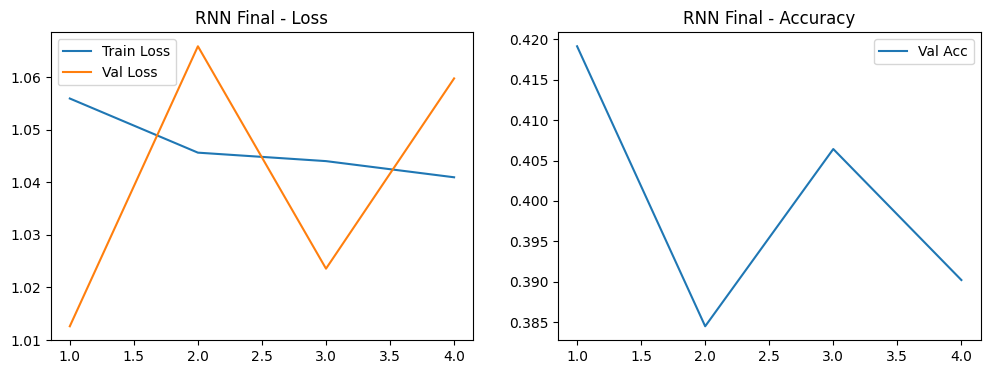


--- דוגמאות לטעות (Medium -> Hard) ---
1) who wrote the screenplay for director barbe schroeder's palme d'or winning movie

2) herieth paul is a tanzanian fashion model who has walked for an american fashion designer who directed what 2009 film

3) what year was the actor born that stared in a 1985 american comedy head office

4) piano concerto was premiered by a pianist who has what ethnicity

5) what primarily competed with nintendo 64 and sega staurn has a horror themed adventure game published by jaleco in 1999



In [ ]:
# ==========================================
# 2. הגדרות והרצת הניסוי (מעודכן עם Batch Size)
# ==========================================

# --- כאן את משנה את ההיפר-פרמטרים ---
MODEL_TYPE = 'RNN'
IS_BIDIRECTIONAL = False
DROPOUT_P = 0.0
LEARNING_RATE = 0.001
BATCH_SIZE = 32           # <--- הנה הוא! נסי 32, 64 או 128
EPOCHS = 10
HIDDEN_DIM = 128
N_LAYERS = 1
PATIENCE = 3
IS_FROZEN = True          # הקפאת ה-Embedding כפי שביקשת
label_map = {0: 'Easy', 1: 'Medium', 2: 'Hard'}

# 1. הגדרה מחדש של ה-Loaders עם ה-Batch Size החדש
# (זה הכרחי כדי שהשינוי ב-Batch Size באמת יקרה)
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# 2. בניית המודל
model_experiment = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=HIDDEN_DIM,
    output_dim=3,
    n_layers=N_LAYERS,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    #embedding_matrix=EMBED_MAT if 'EMBED_MAT' in locals() else None,
    #is_frozen=IS_FROZEN,
    dropout_p=DROPOUT_P
).to(device)

print(f"--- מריץ ניסוי: {MODEL_TYPE} | BS={BATCH_SIZE} | Frozen={IS_FROZEN} ---")

# 3. הרצת האימון
history = run_experiment(
    model_experiment,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    patience=PATIENCE
)

# 4. הצגת תוצאות, מטריצת בלבול וטעויות
print_evaluation_section_c(model_experiment, test_loader)
plot_training_history(history, model_name=f"{MODEL_TYPE} Final")
print_misclassifications(model_experiment, test_loader, device, tokenizer, label_map)

--- מריץ ניסוי: RNN | BS=64 | Frozen=True ---
Epoch 1/10 | Val Loss: 1.0325 | Val Acc: 0.4074
Epoch 2/10 | Val Loss: 0.9819 | Val Acc: 0.4570
Epoch 3/10 | Val Loss: 0.9851 | Val Acc: 0.4510
Epoch 4/10 | Val Loss: 0.9804 | Val Acc: 0.4526
Epoch 5/10 | Val Loss: 0.9748 | Val Acc: 0.4558
Epoch 6/10 | Val Loss: 0.9694 | Val Acc: 0.4637
Epoch 7/10 | Val Loss: 0.9903 | Val Acc: 0.4548
Epoch 8/10 | Val Loss: 0.9782 | Val Acc: 0.4545
Epoch 9/10 | Val Loss: 0.9712 | Val Acc: 0.4618
Early stopping at epoch 9

              precision    recall  f1-score   support

        Easy       0.74      0.44      0.55      1050
      Medium       0.35      0.04      0.07      1050
        Hard       0.38      0.88      0.53      1050

    accuracy                           0.45      3150
   macro avg       0.49      0.45      0.38      3150
weighted avg       0.49      0.45      0.38      3150



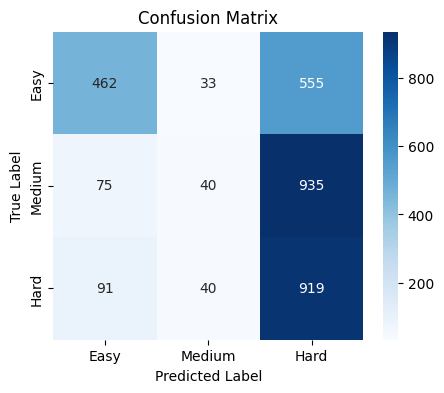

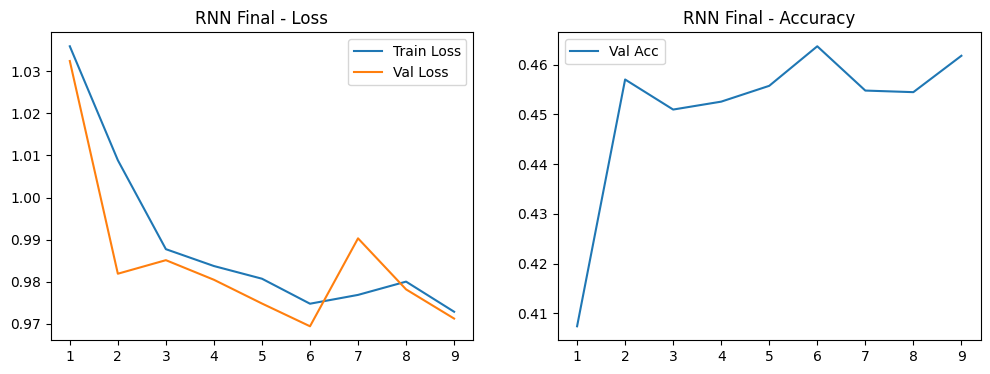


--- דוגמאות לטעות (Medium -> Hard) ---
1) who wrote the screenplay for director barbe schroeder's palme d'or winning movie

2) herieth paul is a tanzanian fashion model who has walked for an american fashion designer who directed what 2009 film

3) what year was the actor born that stared in a 1985 american comedy head office

4) piano concerto was premiered by a pianist who has what ethnicity

5) what primarily competed with nintendo 64 and sega staurn has a horror themed adventure game published by jaleco in 1999



In [ ]:
# ==========================================
# 2. הגדרות והרצת הניסוי (מעודכן עם Batch Size)
# ==========================================

# --- כאן את משנה את ההיפר-פרמטרים ---
MODEL_TYPE = 'RNN'
IS_BIDIRECTIONAL = False
DROPOUT_P = 0.2
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
EPOCHS = 10
HIDDEN_DIM = 128
N_LAYERS = 3
PATIENCE = 3
IS_FROZEN = True          # הקפאת ה-Embedding כפי שביקשת
label_map = {0: 'Easy', 1: 'Medium', 2: 'Hard'}

# 1. הגדרה מחדש של ה-Loaders עם ה-Batch Size החדש
# (זה הכרחי כדי שהשינוי ב-Batch Size באמת יקרה)
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# 2. בניית המודל
model_experiment = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=HIDDEN_DIM,
    output_dim=3,
    n_layers=N_LAYERS,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    #embedding_matrix=EMBED_MAT if 'EMBED_MAT' in locals() else None,
    #is_frozen=IS_FROZEN,
    dropout_p=DROPOUT_P
).to(device)

print(f"--- מריץ ניסוי: {MODEL_TYPE} | BS={BATCH_SIZE} | Frozen={IS_FROZEN} ---")

# 3. הרצת האימון
history = run_experiment(
    model_experiment,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    patience=PATIENCE
)

# 4. הצגת תוצאות, מטריצת בלבול וטעויות
print_evaluation_section_c(model_experiment, test_loader)
plot_training_history(history, model_name=f"{MODEL_TYPE} Final")
print_misclassifications(model_experiment, test_loader, device, tokenizer, label_map)

/tmp/ipython-input-2433062993.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


--- מריץ ניסוי: RNN | BS=32 | Frozen=True ---
Epoch 1/10 | Val Loss: 0.9861 | Val Acc: 0.4586
Epoch 2/10 | Val Loss: 1.0604 | Val Acc: 0.4017
Epoch 3/10 | Val Loss: 0.9879 | Val Acc: 0.4459
Epoch 4/10 | Val Loss: 0.9787 | Val Acc: 0.4554
Epoch 5/10 | Val Loss: 1.0774 | Val Acc: 0.3740
Epoch 6/10 | Val Loss: 1.0182 | Val Acc: 0.4157
Epoch 7/10 | Val Loss: 1.0013 | Val Acc: 0.4354
Early stopping at epoch 7

              precision    recall  f1-score   support

        Easy       0.81      0.40      0.54      1050
      Medium       0.38      0.96      0.55      1050
        Hard       0.00      0.00      0.00      1050

    accuracy                           0.45      3150
   macro avg       0.40      0.45      0.36      3150
weighted avg       0.40      0.45      0.36      3150



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


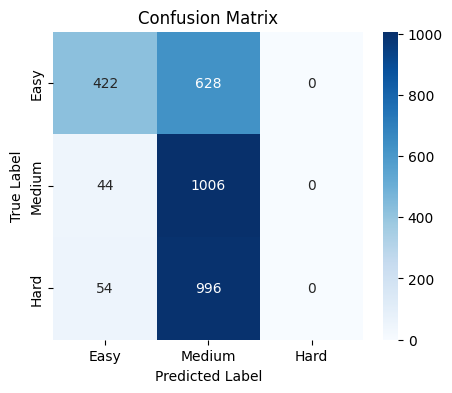

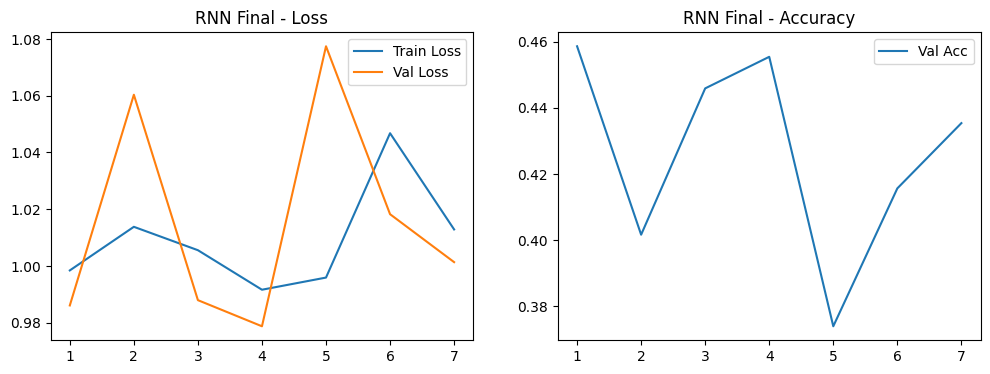


--- דוגמאות לטעות (Medium -> Hard) ---


In [ ]:
# ==========================================
# 2. הגדרות והרצת הניסוי (מעודכן עם Batch Size)
# ==========================================

# --- כאן את משנה את ההיפר-פרמטרים ---
MODEL_TYPE = 'RNN'
IS_BIDIRECTIONAL = False
DROPOUT_P = 0.0
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_DIM = 128
N_LAYERS = 1
PATIENCE = 3
IS_FROZEN = True          # הקפאת ה-Embedding כפי שביקשת
label_map = {0: 'Easy', 1: 'Medium', 2: 'Hard'}

# 1. הגדרה מחדש של ה-Loaders עם ה-Batch Size החדש
# (זה הכרחי כדי שהשינוי ב-Batch Size באמת יקרה)
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# 2. בניית המודל
model_experiment = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=HIDDEN_DIM,
    output_dim=3,
    n_layers=N_LAYERS,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    embedding_matrix=EMBED_MAT if 'EMBED_MAT' in locals() else None,
    is_frozen=IS_FROZEN,
    dropout_p=DROPOUT_P
).to(device)

print(f"--- מריץ ניסוי: {MODEL_TYPE} | BS={BATCH_SIZE} | Frozen={IS_FROZEN} ---")

# 3. הרצת האימון
history = run_experiment(
    model_experiment,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    patience=PATIENCE
)

# 4. הצגת תוצאות, מטריצת בלבול וטעויות
print_evaluation_section_c(model_experiment, test_loader)
plot_training_history(history, model_name=f"{MODEL_TYPE} Final")
print_misclassifications(model_experiment, test_loader, device, tokenizer, label_map)

/tmp/ipython-input-2433062993.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


--- מריץ ניסוי: RNN | BS=32 | Frozen=False ---
Epoch 1/10 | Val Loss: 0.9881 | Val Acc: 0.4580
Epoch 2/10 | Val Loss: 0.9755 | Val Acc: 0.4567
Epoch 3/10 | Val Loss: 1.0203 | Val Acc: 0.4293
Epoch 4/10 | Val Loss: 0.9853 | Val Acc: 0.4545
Epoch 5/10 | Val Loss: 1.0552 | Val Acc: 0.3857
Early stopping at epoch 5

              precision    recall  f1-score   support

        Easy       0.76      0.44      0.56      1050
      Medium       0.00      0.00      0.00      1050
        Hard       0.38      0.93      0.54      1050

    accuracy                           0.45      3150
   macro avg       0.38      0.45      0.37      3150
weighted avg       0.38      0.45      0.37      3150



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


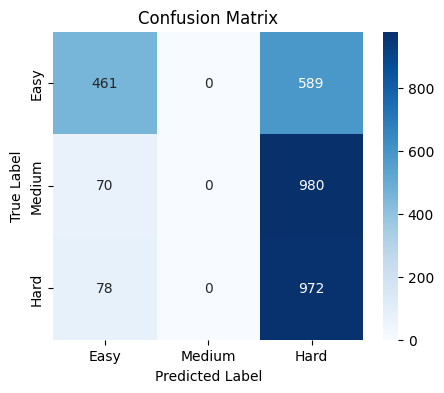

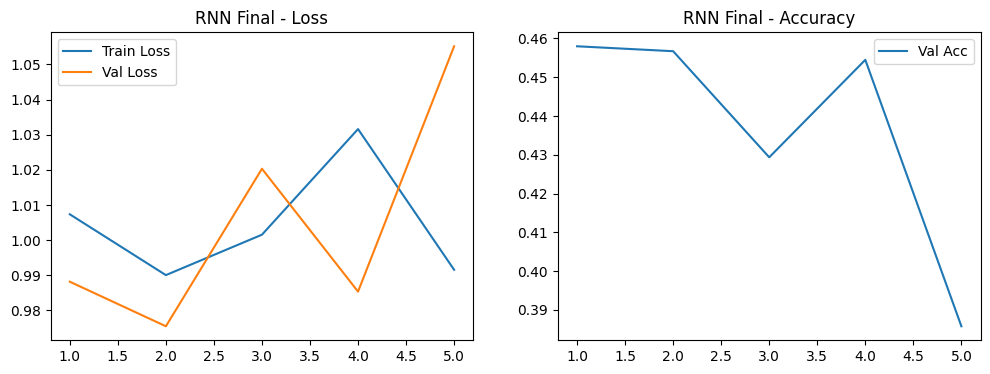


--- דוגמאות לטעות (Medium -> Hard) ---
1) who wrote the screenplay for director barbe schroeder's palme d'or winning movie

2) herieth paul is a tanzanian fashion model who has walked for an american fashion designer who directed what 2009 film

3) what year was the actor born that stared in a 1985 american comedy head office

4) piano concerto was premiered by a pianist who has what ethnicity

5) what primarily competed with nintendo 64 and sega staurn has a horror themed adventure game published by jaleco in 1999



In [ ]:
# ==========================================
# 2. הגדרות והרצת הניסוי (מעודכן עם Batch Size)
# ==========================================

# --- כאן את משנה את ההיפר-פרמטרים ---
MODEL_TYPE = 'RNN'
IS_BIDIRECTIONAL = False
DROPOUT_P = 0.0
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_DIM = 128
N_LAYERS = 1
PATIENCE = 3
IS_FROZEN = False          # הקפאת ה-Embedding כפי שביקשת
label_map = {0: 'Easy', 1: 'Medium', 2: 'Hard'}

# 1. הגדרה מחדש של ה-Loaders עם ה-Batch Size החדש
# (זה הכרחי כדי שהשינוי ב-Batch Size באמת יקרה)
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# 2. בניית המודל
model_experiment = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=HIDDEN_DIM,
    output_dim=3,
    n_layers=N_LAYERS,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    embedding_matrix=EMBED_MAT if 'EMBED_MAT' in locals() else None,
    is_frozen=IS_FROZEN,
    dropout_p=DROPOUT_P
).to(device)

print(f"--- מריץ ניסוי: {MODEL_TYPE} | BS={BATCH_SIZE} | Frozen={IS_FROZEN} ---")

# 3. הרצת האימון
history = run_experiment(
    model_experiment,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    patience=PATIENCE
)

# 4. הצגת תוצאות, מטריצת בלבול וטעויות
print_evaluation_section_c(model_experiment, test_loader)
plot_training_history(history, model_name=f"{MODEL_TYPE} Final")
print_misclassifications(model_experiment, test_loader, device, tokenizer, label_map)

/tmp/ipython-input-2433062993.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


--- מריץ ניסוי: RNN | BS=32 | Frozen=False ---
Epoch 1/10 | Val Loss: 1.0159 | Val Acc: 0.4583
Epoch 2/10 | Val Loss: 1.0084 | Val Acc: 0.4402
Epoch 3/10 | Val Loss: 1.0070 | Val Acc: 0.4589
Epoch 4/10 | Val Loss: 1.0671 | Val Acc: 0.4211
Epoch 5/10 | Val Loss: 1.0001 | Val Acc: 0.4300
Epoch 6/10 | Val Loss: 0.9862 | Val Acc: 0.4577
Epoch 7/10 | Val Loss: 0.9782 | Val Acc: 0.4574
Epoch 8/10 | Val Loss: 1.0102 | Val Acc: 0.4484
Epoch 9/10 | Val Loss: 0.9802 | Val Acc: 0.4551
Epoch 10/10 | Val Loss: 0.9905 | Val Acc: 0.4593
Early stopping at epoch 10

              precision    recall  f1-score   support

        Easy       0.74      0.43      0.55      1050
      Medium       0.39      0.93      0.55      1050
        Hard       0.00      0.00      0.00      1050

    accuracy                           0.46      3150
   macro avg       0.38      0.46      0.36      3150
weighted avg       0.38      0.46      0.36      3150



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


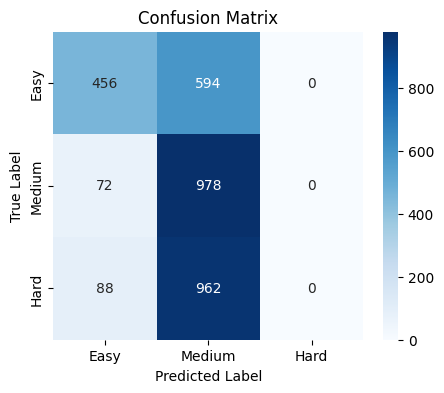

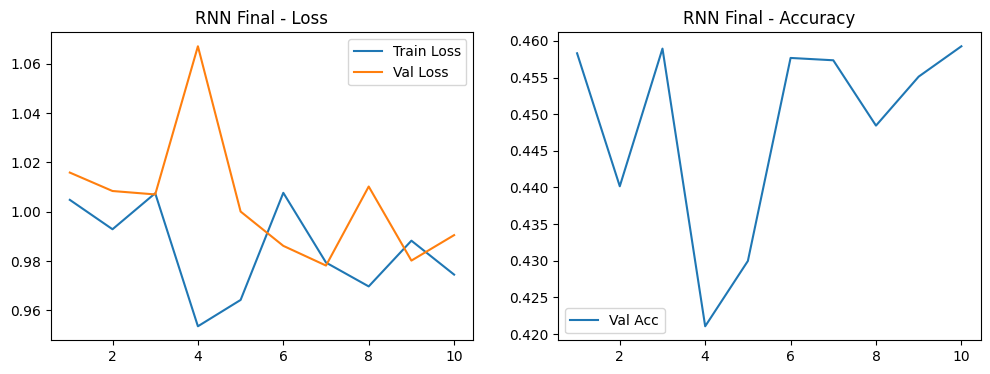


--- דוגמאות לטעות (Medium -> Hard) ---


In [ ]:
# ==========================================
# 2. הגדרות והרצת הניסוי (מעודכן עם Batch Size)
# ==========================================

# --- כאן את משנה את ההיפר-פרמטרים ---
MODEL_TYPE = 'RNN'
IS_BIDIRECTIONAL = False
DROPOUT_P = 0.2
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_DIM = 128
N_LAYERS = 1
PATIENCE = 3
IS_FROZEN = False          # הקפאת ה-Embedding כפי שביקשת
label_map = {0: 'Easy', 1: 'Medium', 2: 'Hard'}

# 1. הגדרה מחדש של ה-Loaders עם ה-Batch Size החדש
# (זה הכרחי כדי שהשינוי ב-Batch Size באמת יקרה)
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# 2. בניית המודל
model_experiment = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=HIDDEN_DIM,
    output_dim=3,
    n_layers=N_LAYERS,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    embedding_matrix=EMBED_MAT if 'EMBED_MAT' in locals() else None,
    is_frozen=IS_FROZEN,
    dropout_p=DROPOUT_P
).to(device)

print(f"--- מריץ ניסוי: {MODEL_TYPE} | BS={BATCH_SIZE} | Frozen={IS_FROZEN} ---")

# 3. הרצת האימון
history = run_experiment(
    model_experiment,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    patience=PATIENCE
)

# 4. הצגת תוצאות, מטריצת בלבול וטעויות
print_evaluation_section_c(model_experiment, test_loader)
plot_training_history(history, model_name=f"{MODEL_TYPE} Final")
print_misclassifications(model_experiment, test_loader, device, tokenizer, label_map)

/tmp/ipython-input-2433062993.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


--- מריץ ניסוי: RNN | BS=32 | Frozen=False ---
Epoch 1/10 | Val Loss: 1.0196 | Val Acc: 0.4150
Epoch 2/10 | Val Loss: 1.0306 | Val Acc: 0.4519
Epoch 3/10 | Val Loss: 0.9898 | Val Acc: 0.4472
Epoch 4/10 | Val Loss: 0.9805 | Val Acc: 0.4554
Epoch 5/10 | Val Loss: 1.0087 | Val Acc: 0.4319
Epoch 6/10 | Val Loss: 0.9778 | Val Acc: 0.4564
Epoch 7/10 | Val Loss: 0.9800 | Val Acc: 0.4561
Epoch 8/10 | Val Loss: 0.9643 | Val Acc: 0.4647
Epoch 9/10 | Val Loss: 0.9966 | Val Acc: 0.4516
Epoch 10/10 | Val Loss: 1.0060 | Val Acc: 0.4723

              precision    recall  f1-score   support

        Easy       0.76      0.43      0.55      1050
      Medium       0.42      0.53      0.47      1050
        Hard       0.37      0.43      0.40      1050

    accuracy                           0.46      3150
   macro avg       0.52      0.46      0.47      3150
weighted avg       0.52      0.46      0.47      3150



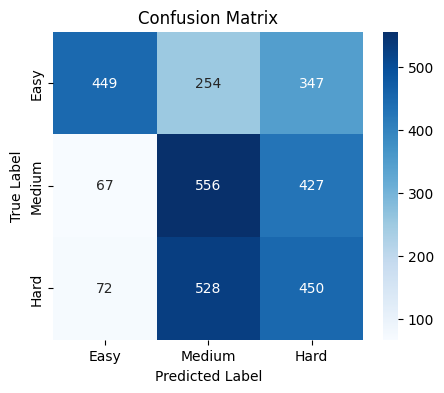

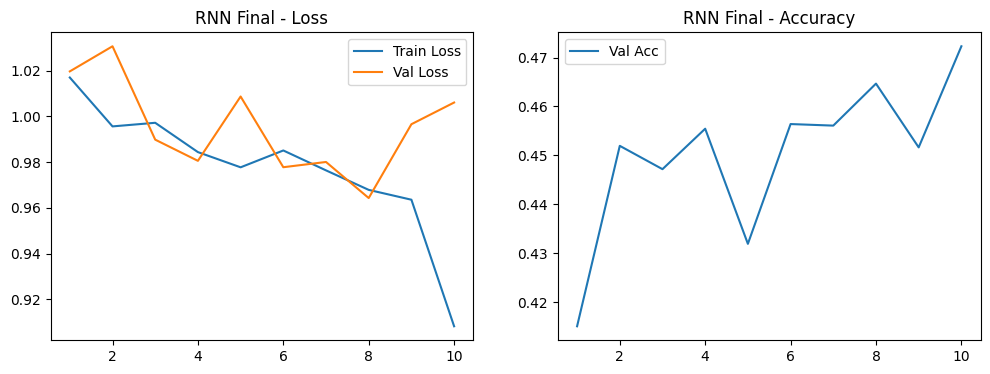


--- דוגמאות לטעות (Medium -> Hard) ---
1) who wrote the screenplay for director barbe schroeder's palme d'or winning movie

2) piano concerto was premiered by a pianist who has what ethnicity

3) simone simeri plays for the italian team from what state

4) who is older wang shuang or lionel messi

5) in which movie did olivia thirlby play the part of pregnant teen ellen page



In [ ]:
# ==========================================
# 2. הגדרות והרצת הניסוי (מעודכן עם Batch Size)
# ==========================================

# --- כאן את משנה את ההיפר-פרמטרים ---
MODEL_TYPE = 'RNN'
IS_BIDIRECTIONAL = False
DROPOUT_P = 0.3
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_DIM = 128
N_LAYERS = 1
PATIENCE = 3
IS_FROZEN = False          # הקפאת ה-Embedding כפי שביקשת
label_map = {0: 'Easy', 1: 'Medium', 2: 'Hard'}

# 1. הגדרה מחדש של ה-Loaders עם ה-Batch Size החדש
# (זה הכרחי כדי שהשינוי ב-Batch Size באמת יקרה)
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# 2. בניית המודל
model_experiment = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=HIDDEN_DIM,
    output_dim=3,
    n_layers=N_LAYERS,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    embedding_matrix=EMBED_MAT if 'EMBED_MAT' in locals() else None,
    is_frozen=IS_FROZEN,
    dropout_p=DROPOUT_P
).to(device)

print(f"--- מריץ ניסוי: {MODEL_TYPE} | BS={BATCH_SIZE} | Frozen={IS_FROZEN} ---")

# 3. הרצת האימון
history = run_experiment(
    model_experiment,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    patience=PATIENCE
)

# 4. הצגת תוצאות, מטריצת בלבול וטעויות
print_evaluation_section_c(model_experiment, test_loader)
plot_training_history(history, model_name=f"{MODEL_TYPE} Final")
print_misclassifications(model_experiment, test_loader, device, tokenizer, label_map)

/tmp/ipython-input-2433062993.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


--- מריץ ניסוי: RNN | BS=32 | Frozen=False ---
Epoch 1/8 | Val Loss: 0.9737 | Val Acc: 0.4551
Epoch 2/8 | Val Loss: 1.0451 | Val Acc: 0.3940
Epoch 3/8 | Val Loss: 1.0348 | Val Acc: 0.4032
Epoch 4/8 | Val Loss: 0.9800 | Val Acc: 0.4561
Early stopping at epoch 4

              precision    recall  f1-score   support

        Easy       0.75      0.43      0.55      1050
      Medium       0.42      0.29      0.34      1050
        Hard       0.38      0.66      0.49      1050

    accuracy                           0.46      3150
   macro avg       0.52      0.46      0.46      3150
weighted avg       0.52      0.46      0.46      3150



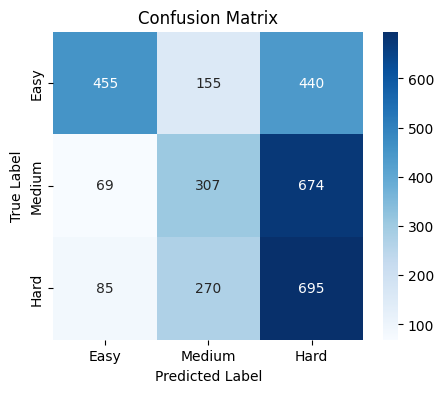

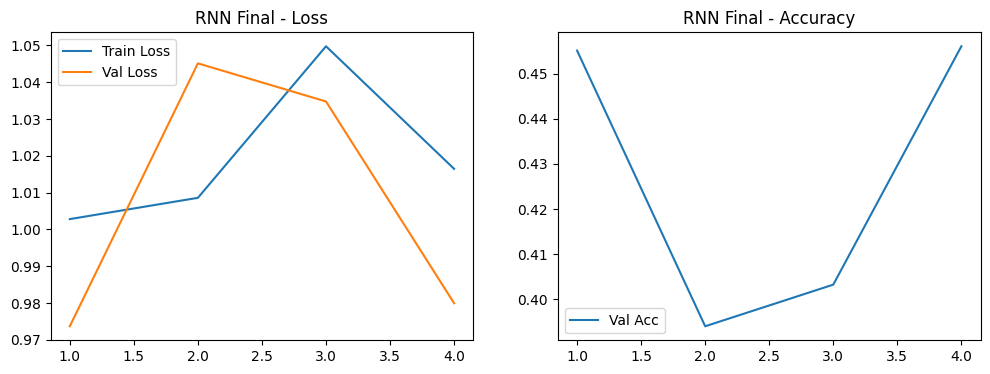


--- דוגמאות לטעות (Medium -> Hard) ---
1) who wrote the screenplay for director barbe schroeder's palme d'or winning movie

2) what year was the actor born that stared in a 1985 american comedy head office

3) piano concerto was premiered by a pianist who has what ethnicity

4) simone simeri plays for the italian team from what state

5) who is older wang shuang or lionel messi



In [ ]:
# ==========================================
# 2. הגדרות והרצת הניסוי (מעודכן עם Batch Size)
# ==========================================

# --- כאן את משנה את ההיפר-פרמטרים ---
MODEL_TYPE = 'RNN'
IS_BIDIRECTIONAL = False
DROPOUT_P = 0.3
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 8
HIDDEN_DIM = 128
N_LAYERS = 1
PATIENCE = 3
IS_FROZEN = False          # הקפאת ה-Embedding כפי שביקשת
label_map = {0: 'Easy', 1: 'Medium', 2: 'Hard'}

# 1. הגדרה מחדש של ה-Loaders עם ה-Batch Size החדש
# (זה הכרחי כדי שהשינוי ב-Batch Size באמת יקרה)
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

# 2. בניית המודל
model_experiment = FlexibleModel(
    vocab_size=36543,
    embed_dim=100,
    hidden_dim=HIDDEN_DIM,
    output_dim=3,
    n_layers=N_LAYERS,
    model_type=MODEL_TYPE,
    bidirectional=IS_BIDIRECTIONAL,
    embedding_matrix=EMBED_MAT if 'EMBED_MAT' in locals() else None,
    is_frozen=IS_FROZEN,
    dropout_p=DROPOUT_P
).to(device)

print(f"--- מריץ ניסוי: {MODEL_TYPE} | BS={BATCH_SIZE} | Frozen={IS_FROZEN} ---")

# 3. הרצת האימון
history = run_experiment(
    model_experiment,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    patience=PATIENCE
)

# 4. הצגת תוצאות, מטריצת בלבול וטעויות
print_evaluation_section_c(model_experiment, test_loader)
plot_training_history(history, model_name=f"{MODEL_TYPE} Final")
print_misclassifications(model_experiment, test_loader, device, tokenizer, label_map)